# AircraftFuelConsumption
Competition with dataset:https://www.crowdanalytix.com/contests/predict-fuel-flow-rate-of-airplanes-during-different-phases-of-a-flight

# Imoptrs

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd '/content/drive/My Drive/FuelProject/data'

/content/drive/My Drive/FuelProject/data


In [0]:
!pip3 install eli5
!pip3 install pdpbox
!pip3 install category_encoders

In [0]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_error
from pdpbox import pdp, get_dataset, info_plots
from sklearn.feature_selection import f_regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from scipy.stats import mode
import matplotlib.font_manager

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
def compr(list_it,remove_it):
  return [x for x in list_it if x not in remove_it]

def ppl_to_df(ppl,name,X,y,fit=True):
  if(fit):
    trans=ppl.fit_transform(X,y)
  else:
    trans=ppl.transform(X)
  ndf = pd.DataFrame(trans,columns=ppl[name].get_feature_names(),index=X.index).astype("float")
  return ndf.rename(columns=lambda x: re.findall("\_\_(.*)\Z",x)[0])

def feat_importance(m, df,plot=False,top=10):
    imp_df = pd.DataFrame({'cols':df.columns, 'imp':m}
                       ).sort_values('imp', ascending=False)
    if(plot):
      fig, axbo = plt.subplots(1, 1, figsize=(10, 6))
      sns.barplot(x="cols",y="imp",data=imp_df[:top],palette="Blues_d",ax=axbo)
      plt.show()
    return imp_df.set_index("cols")

def clean_split(struct_cleaned,beg,fin,y_name):
  ids=struct_cleaned["Flight_instance_ID"].unique()[beg:fin]
  cleaned=struct_cleaned[struct_cleaned["Flight_instance_ID"].isin(ids)]
  return (cleaned.drop(columns=y_name),cleaned["FF"])

def mix_split(df,sort,target,ids,size):
  sorteddf = df.sort_values(by=sort)
  top = sorteddf[:size]
  X = top.drop(columns=target)
  y = top[target]
  rest = sorteddf[size:]
  return X,y,rest[~rest[ids].isin(X[ids])]

def drop_unvariance(traine):
  z_cols=traine.columns[traine.var()==0]
  return traine.drop(columns=z_cols)

def smart_subsample(df,ids,sam):
  dfs=df.reset_index()
  grouped=dfs.groupby([ids])["index"]
  reserve = grouped.min().append(grouped.max())
  mask = dfs["index"].isin(reserve.values)
  takesamp = lambda d: d.sample(sam)
  todrop = dfs[~mask].groupby(ids).apply(takesamp)
  return df.drop(todrop["index"].values)

def remove_rows_val(df,val,col):
  return df[df[col]!=val].astype("float")

def elapsed(df,beg,fin):
  df["elapsed"]=pd.to_datetime(df.iloc[:, beg:fin]).astype("int")/1000000000
  return df.sort_values(by=["elapsed"])

class DoNothing(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass
    def fit(self,x=None,y=None):
      self.params = x.columns
      return self
    def transform(self,x=None):
      return x
    def get_feature_names(self):
      return list(self.params)

class FlightPart(BaseEstimator, TransformerMixin):
    def __init__(self,elapsed,ids):
      self.elapsed = elapsed
      self.ids = ids
      pass
    def fit(self,x=None,y=None):
      self.params = x.columns
     
      return self
    def transform(self,X=None):
      strats = X.groupby(self.ids)[self.elapsed].min()
      
      finishes = X.groupby(self.ids)[self.elapsed].max()
      
      X["from_beg"]=X[self.elapsed]-strats[X[self.ids]].values
      X["duration"]=finishes[X[self.ids]].values-strats[X[self.ids]].values
      X["part"]=X["from_beg"]/X["duration"]
      X.drop(columns=self.ids,inplace=True)

      self.params = X.columns
      return X
    def get_feature_names(self):
      return list(self.params)

class MintoMean(BaseEstimator, TransformerMixin):
    def __init__(self,miss):
      self.miss = miss
      self.minv={}
      self.mean={}
    def fit(self,x=None,y=None):
      self.params = x.columns
      self.minv=x.apply(lambda cval:cval.min(),axis=0)+self.miss
      self.mean=x.apply(lambda cval:cval[cval>cval.min()].mean(),axis=0)
      return self
    def transform(self,x=None):
      for col in x.columns:
        x[col+"_out"]=(x[col]<self.minv[col])
        x[col].where(x[col]>self.minv[col],other=self.mean[col],inplace=True)
      self.params = x.columns
      return x
    def get_feature_names(self):
      return list(self.params)

class ClustTarg(BaseEstimator, TransformerMixin):
    def __init__(self,n_clust):
      self.n_clust=n_clust
      pass
    def fit(self,x=None,y=None):
      self.params = x.columns
      self.kmn_mod={}
      self.trg_mod={}
      for col in x.columns:
        tmp=pd.DataFrame([])
        self.kmn_mod[col] = KMeans(n_clusters=self.n_clust[col])
        self.kmn_mod[col].fit(np.reshape(x[col].values,(-1,1)))

        tmp[col]= self.kmn_mod[col].predict(np.reshape(x[col].values,(-1,1)))
        self.trg_mod[col]=TargetEncoder()
        self.trg_mod[col].fit(tmp[col].astype("category"),train_y)
      return self
    def transform(self,X=None):
      for col in X.columns:
        X[col]= self.kmn_mod[col].predict(np.reshape(X[col].values,(-1,1)))
        X[col] = self.trg_mod[col].transform(X[col].astype("category"))
      return X
    def get_feature_names(self):
      return list(self.params)

class CorrCount:

  def __init__(self,dataset,coeff):
    correlation = dataset.corr()
    correlation.dropna(axis=0,how="all",inplace=True)
    correlation.dropna(axis=1,how="all",inplace=True)
    
    col1=pd.Series(correlation.index).repeat(correlation.iloc[0].size).reset_index()
    col2=pd.concat([pd.Series(correlation.index)]*correlation.iloc[0].size).reset_index()
    col3=pd.Series(np.squeeze(correlation.values.reshape(-1,1))).reset_index()
    
    corrtab=pd.DataFrame({"col1":col1[0],"col2":col2[0],"coef":col3[0]})
    corrtab=corrtab[corrtab["col1"]!=corrtab["col2"]]

    self.correlation = correlation
    self.highcorrtab = corrtab[((corrtab["coef"]>coeff)|(corrtab["coef"]<coeff*-1))]

  def betterval(self,impor,feat_X):

    def to_remove(feat,imortance):
      if((imortance.loc[feat["col1"]]<imortance.loc[feat["col2"]]).bool()):
        return feat["col1"]
      else:
        return False

    rem = self.highcorrtab.apply(lambda x:to_remove(x,impor),axis=1).unique()
    rem = rem[rem!=False]
    return feat_X.drop(columns=rem)






# Data

In [0]:
test_sam = pd.read_csv("CAX_Test_sub.csv")

In [0]:
traine = pd.read_csv("train_unstruc.csv")

In [0]:
traine = remove_rows_val(traine,"Year","Year")
traine = drop_unvariance(traine)
traine = elapsed(traine,1,7)

# Train test selection

In this section RF is used to predict which line is from test set and which from train set. Then feature importance shows difference beween thouse sets.


In [0]:
train_sam=traine.sample(50000)

In [0]:
test_sam.drop(columns=["FF"],inplace=True)
train_sam.drop(columns=["FF","elapsed"],inplace=True)
test_sam["Predictor"]=0
train_sam["Predictor"]=1
search_df = test_sam[train_sam.columns].append(train_sam)

In [0]:
split_model = RandomForestClassifier(n_estimators=75)
split_model.fit(search_df.drop(columns=["Predictor"]),search_df["Predictor"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

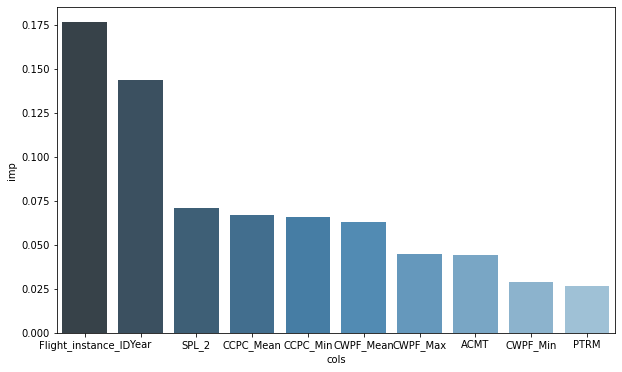

In [0]:
_ = feat_importance(split_model.feature_importances_,search_df.drop(columns=["Predictor"]),True)

In [0]:
print("Train: "+str(train_sam["Year"].unique()))
print("Test: "+str(test_sam["Year"].unique()))

Train: [2004. 2003. 2002.]
Test: [2001.]




*   This bar chart shows that Data in test set is from years before train data.
*   "Flight_instance_ID" in different sets should not intercept.



#Mixed data

Data in this dataset is taken randomly form different flights. So model can approximate better.

In [0]:
val_X,val_y,rest = mix_split(traine,["Year","Month"],"FF","Flight_instance_ID",50000)
test_X,test_y,rest = mix_split(rest,["Year","Month"],"FF","Flight_instance_ID",50000)
train_X,train_y,_ = mix_split(rest.sample(350000),["Year","Month"],"FF","Flight_instance_ID",-1)

#Complete data

This dataset contains all known data about each flight in it. So there is more opportunities for preprocessing.

In [0]:
traine_cm = pd.read_csv("train_struc.csv")
traine_cm = remove_rows_val(traine_cm,"Year","Year")
traine_cm = elapsed(traine_cm,2,8)

In [0]:
traine_cm["Flight_instance_ID"].unique().size

143

In this set there is data about 143 unique flights

In [0]:
traine_cm.head(5)

,ACID,Flight_instance_ID,Year,Month,Day,Hour,Minute,Second,ABRK,ELEV_1,ELEV_2,EVNT,FADF,FADS,FGC3,FIRE_1,FIRE_2,FIRE_3,FIRE_4,FLAP,FQTY_1,FQTY_2,FQTY_3,FQTY_4,GLS,GPWS,HDGS,HF1,HF2,HYDG,HYDY,ILSF,LATP,LMOD,LOC,LONP,MNS,MRK,MW,N1CO,...,WS_Mean,WS_Min,WS_Max,RALT_Mean,RALT_Min,RALT_Max,ROLL_Mean,ROLL_Min,ROLL_Max,VRTG_Mean,VRTG_Min,VRTG_Max,CTAC_Mean,CTAC_Min,CTAC_Max,FPAC_Mean,FPAC_Min,FPAC_Max,IVV_Mean,IVV_Min,IVV_Max,ACMT,AIL_1,AIL_2,ALTS,APFD,A_T,BLV,BPGR_1,BPGR_2,BPYR_1,BPYR_2,CALT,CASS,CRSS,DFGS,DWPT,EAI,FF,elapsed
145706,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,12.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,95.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.005488,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.78125,-0.875,-0.75,-0.406483,-0.406483,-0.406483,0.988978,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.8750,-1.0,0.0,60.0,85.086838,81.997681,5000.0,2.0,1.0,0.0,0.0,48.828247,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145707,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,13.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,94.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,0.000000,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.81250,-0.875,-0.75,-0.402363,-0.406483,-0.395497,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-1.0000,-1.0,-1.0,60.0,85.086838,81.956764,5000.0,2.0,1.0,0.0,0.0,43.945423,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145708,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,14.0,119.96891,21.928959,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,94.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.001176,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.81250,-0.875,-0.75,-0.406483,-0.406483,-0.406483,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.5000,-1.0,0.0,60.0,85.086838,81.977219,5000.0,2.0,1.0,0.0,0.0,48.828247,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145709,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,15.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,95.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.001764,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.78125,-0.875,-0.75,-0.405110,-0.406483,-0.395497,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.1250,-1.0,0.0,60.0,85.066376,81.977219,5000.0,2.0,1.0,0.0,0.0,48.828247,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145710,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,16.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,94.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.013132,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.78125,-0.875,-0.75,-0.399617,-0.406483,-0.395497,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.3125,-1.0,0.0,60.0,85.086838,81.997681,5000.0,2.0,1.0,0.0,0.0,43.945423,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09


In [0]:
traine_cm = smart_subsample(traine_cm,"Flight_instance_ID",3000)
traine_cm=drop_unvariance(traine_cm)

In [0]:
train=traine_cm
val_X,val_y = clean_split(traine_cm,0,20,"FF")
test_X,test_y = clean_split(traine_cm,20,40,"FF")

In [0]:
train_X,train_y = clean_split(traine_cm,40,-1,"FF")

# A little bit of analysis

In [0]:
featcorr = CorrCount(train_X,0.9)

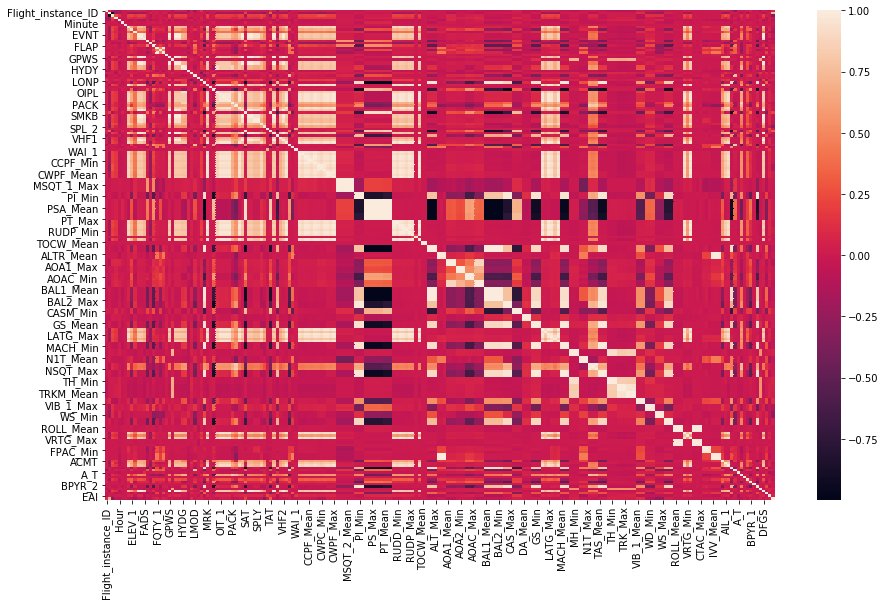

In [0]:
fig, axbo = plt.subplots(1, 1, figsize=(15, 9))
sns.heatmap(featcorr.correlation,ax=axbo)
plt.show()

We can see that in date set many independent features duplicate each other.

#PH analys

This charts represents average fuel consumption during different phases of the flight.

In [0]:
phticks=["Unknown","Preflight","Taxi","Takeoff","Climb","Cruise","Approuch","Rollout"]

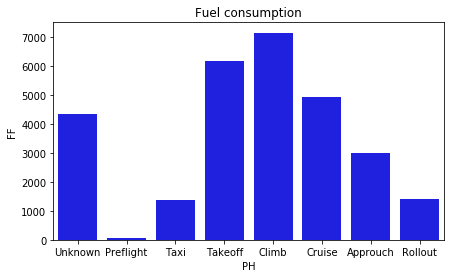

In [0]:
phan=pd.DataFrame(train.groupby("PH").mean()["FF"])
fig, axbo = plt.subplots(1, 1, figsize=(7, 4))
sns.barplot(x=phan.index,y="FF",data=phan,color="blue",ax=axbo)
axbo.set_xticklabels(phticks)
axbo.title.set_text('Fuel consumption')
plt.show()

More about phases: https://www.fp7-restarts.eu/index.php/home/root/state-of-the-art/objectives/2012-02-15-11-58-37/71-book-video/parti-principles-of-flight/126-4-phases-of-a-flight.html

# First model

Mask for training data subsample to train models faster:

In [0]:
msks = 50000
mask=np.concatenate([np.zeros(train_X.shape[0]-msks),np.ones(msks)]).astype("bool")
np.random.shuffle(mask)

First model is calculating of MSE for mean of train set.

In [0]:
mean_squared_error(test_y,[train_y.mean()]*test_y.shape[0])

5452272.701368927

Second model is just RF with random hyper parameters

In [0]:
pre_mod=RandomForestRegressor(n_estimators=25,max_features=100)
pre_mod.fit(train_X[mask].drop(columns="Flight_instance_ID"),train_y[mask])
mean_squared_error(test_y,pre_mod.predict(test_X.drop(columns="Flight_instance_ID")))

53456.114414036965

# Important Features

This cell is about sellecting important features for models. To cover different types of dependencies I use 4 indicators (RF feature importance, Linear Regression feature importance, f-regression, high variance). Also how I mentioned earlier there is many duplicated features in this dataset. The idea is to firstly calculate feature importance for all features and then remove less important feature form each highly correlated group and then calculate importance again.

##RF feature importance

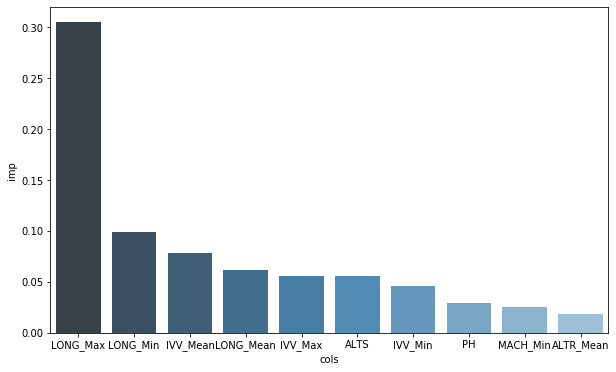

In [0]:
all_imp=feat_importance(pre_mod.feature_importances_,train_X.drop(columns="Flight_instance_ID"),True)

We can see many features that shows (Max, Min, Mean) of same varialbles

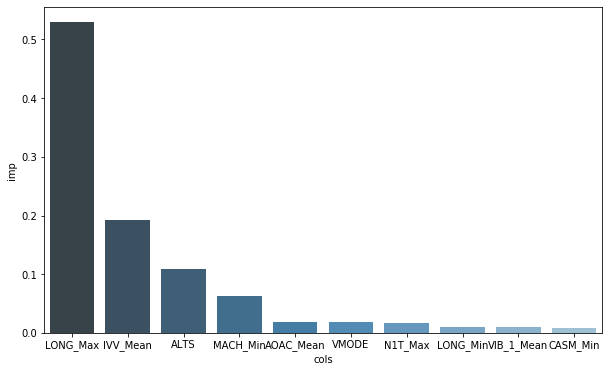

In [0]:
rf_cleaned_X = featcorr.betterval(all_imp,train_X)
cleaned_mod=RandomForestRegressor(n_estimators=25,min_samples_leaf=40)
cleaned_mod.fit(rf_cleaned_X[mask],train_y[mask])
rf_feat=feat_importance(cleaned_mod.feature_importances_,rf_cleaned_X,True)

Now many more unique features appears.

Also there is PDP for feature that RF shows that is the most important (LONG_Max):

<Figure size 504x288 with 0 Axes>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


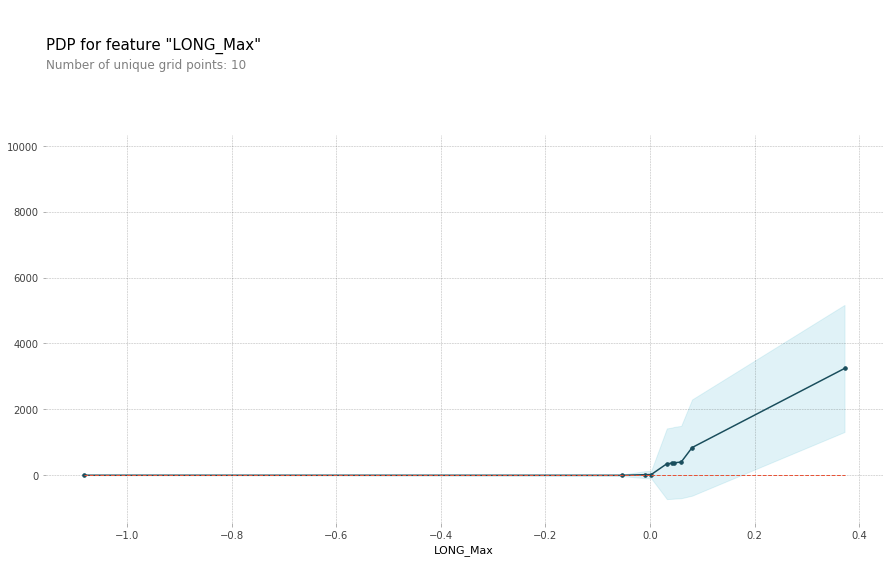

In [0]:
plt.figure(figsize=[7,4])
pdp_goals = pdp.pdp_isolate(model=cleaned_mod, dataset=rf_cleaned_X, model_features=rf_cleaned_X.columns, feature='LONG_Max')
pdp.pdp_plot(pdp_goals, 'LONG_Max')
plt.show()

##Liner regression feature importance

There features are scaled using Standart Scaler. Bar chart shows feature importance after duplicate remove.

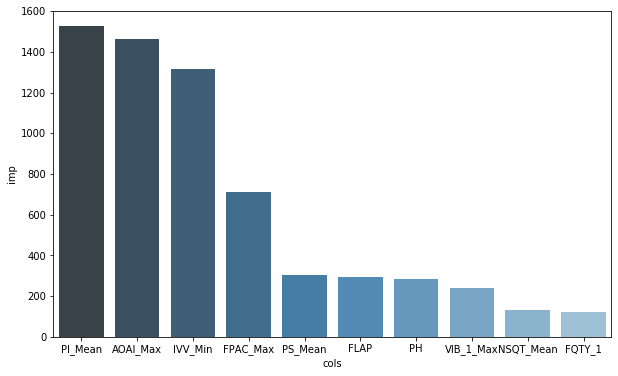

In [0]:
line_ppl=Pipeline(steps=[("reg",StandardScaler())
                    ,("model",LinearRegression())])
line_ppl.fit(train_X.drop(columns="TCAS"),train_y)

line_imp=feat_importance(line_ppl["model"].coef_, train_X.drop(columns="TCAS"))
line_cleaned_X = featcorr.betterval(line_imp,train_X.drop(columns="TCAS"))
line_ppl.fit(line_cleaned_X,train_y)
line_feat=feat_importance(line_ppl["model"].coef_, line_cleaned_X,True)

Reg plot of most important feature:

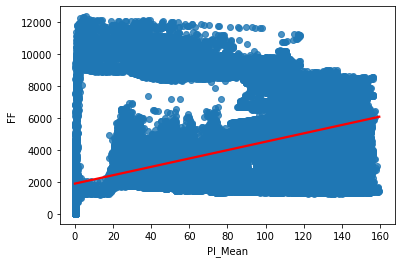

In [0]:
sns.regplot(x="PI_Mean",y="FF",data=train,line_kws={"color": "red"})

##F-regression

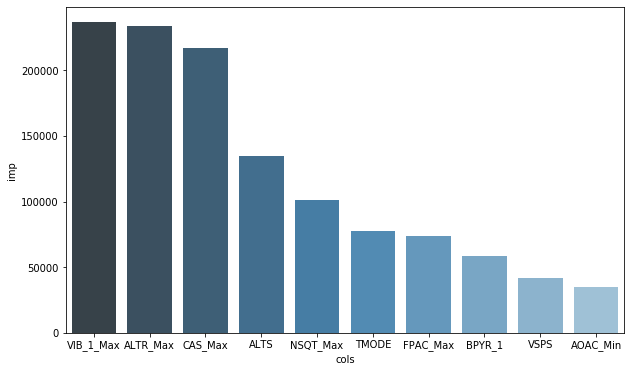

In [0]:
f_imp=feat_importance(f_regression(train_X,train_y)[0], train_X,False)
f_cleaned_X = featcorr.betterval(f_imp,train_X)
f_feat=feat_importance(f_regression(f_cleaned_X,train_y)[0], f_cleaned_X,True)

##Variance

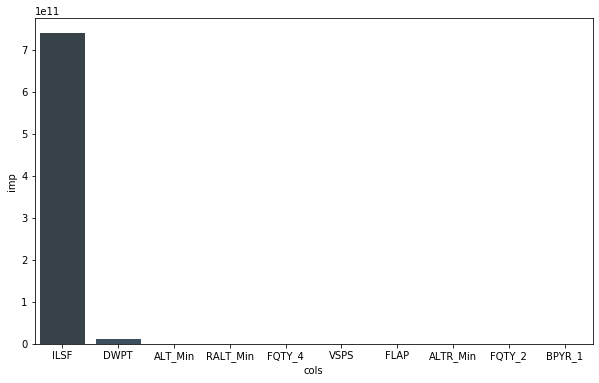

In [0]:
for_var = train_X.drop(columns=["Flight_instance_ID","elapsed"])
var_imp=feat_importance(for_var.var().values, for_var)
var_cleaned_X = featcorr.betterval(var_imp,for_var)
var_feat=feat_importance(var_cleaned_X.var().values, var_cleaned_X,True)

Scatter plot of features with high variance

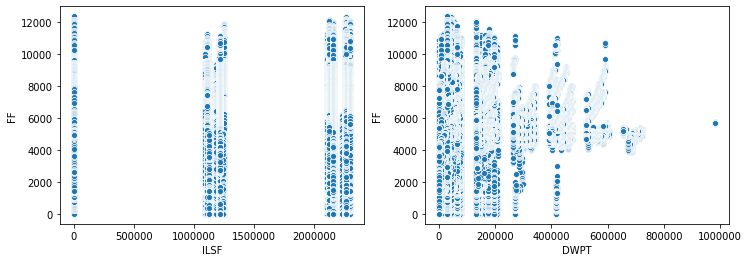

In [0]:
fig, axve = plt.subplots(1,2, figsize=(12, 4))
sns.scatterplot(x="ILSF",y="FF",data=train,ax=axve[0])
sns.scatterplot(x="DWPT",y="FF",data=train,ax=axve[1])
plt.show()

We can see clear clusters of thouse features

##Final train set creation

In [0]:
rf_col=rf_feat[:25].index.values
line_col=line_feat[:10].index.values
f_col=f_feat[:10].index.values
var_col=var_feat[:5].index.values
col_selec=np.unique(np.concatenate((rf_col,line_col,f_col,var_col,["elapsed","Flight_instance_ID"])))
trainimp_X=train_X[col_selec]

In [0]:
forsave= trainimp_X
forsave["FF"]=train_y
forsave.reset_index().to_feather("Backup")

#Preprocessing 

In [0]:
forsave=pd.read_feather("Backup")
trainimp_X=forsave.drop(columns="FF")
trainimp_X.set_index("index",inplace=True)
trainimp_X.index.name=""
train_y=forsave["FF"]
train_y.index=trainimp_X.index

First thing that I noticed is two columns that have high importance according to RF (LONG_Max, CAS_Max) have rows that are deffinetelly an outliers (orange on scatter plots).

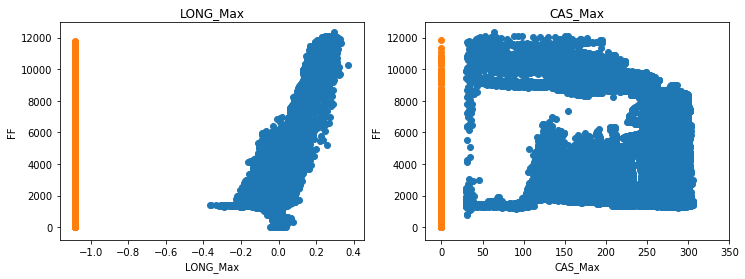

In [0]:
long_out=trainimp_X["LONG_Max"]<-1
cas_out=trainimp_X["CAS_Max"]<3
fig, axve = plt.subplots(1,2, figsize=(12, 4))
axve[0].scatter(trainimp_X[~long_out]["LONG_Max"],train_y[~long_out])
axve[0].scatter(trainimp_X[long_out]["LONG_Max"],train_y[long_out])
axve[0].title.set_text('LONG_Max')
axve[0].set_xlabel('LONG_Max')
axve[0].set_ylabel('FF')
axve[1].scatter(trainimp_X[~cas_out]["CAS_Max"],train_y[~cas_out])
axve[1].scatter(trainimp_X[cas_out]["CAS_Max"],train_y[cas_out])
axve[1].title.set_text('CAS_Max')
axve[1].set_xlabel('CAS_Max')
axve[1].set_ylabel('FF')
axve[1].set_xlim(-20,350)
plt.show()

There is features with less than 15 unique values

In [0]:
unval=trainimp_X.nunique()
unval=unval[unval<15].index

<div>Pipeline for preprocessing.</div>
<div>Encoder:</div>
<div>MintoMean - used for columns with outliers mentioned earlier. Replaces Min value with Mean and creates column with indicators of replced values.</div>
<div>FlightPart - calculte 3 values: duration of a flight, time after beginig and value from 0 to 1 that shows already flown part.</div>
<div>ClustTarg - allows cluster data using K-means algoritm and encode as categorical feature</div>


In [0]:
unval=["OIPL","PH","TMODE","VMODE"]
#trainimp_X[unval]=trainimp_X[unval].astype("category")
others=compr(trainimp_X.columns,["elapsed","Flight_instance_ID","LONG_Max","CAS_Max"])
ct = ColumnTransformer(transformers=[("simdt",MintoMean(0.01),["LONG_Max","CAS_Max"]),
                                     ("flighper",FlightPart("elapsed","Flight_instance_ID"),["elapsed","Flight_instance_ID"]),
                                     ("nother",DoNothing(),others),
                                     #("cltg",ClustTarg({"DWPT":6,"ILSF":5}),["DWPT","ILSF"])
                                     ],remainder="drop")
ppl=Pipeline(steps=[
                    #("target",TargetEncoder(cols=unval)),
                    ("main",ct)

])

In [0]:
train_fin_X=ppl_to_df(ppl,"main",train_X,train_y)
train_fin_X.head(3)

,LONG_Max,CAS_Max,LONG_Max_out,CAS_Max_out,elapsed,from_beg,duration,part,ALTR_Max,ALTS,ALT_Min,AOA1_Mean,AOA2_Min,AOAC_Mean,AOAC_Min,AOAI_Max,AOAI_Min,BPYR_1,CASM_Min,DWPT,EAI,FLAP,FPAC_Max,FQTY_1,FQTY_4,ILSF,IVV_Mean,IVV_Min,LATP,LONG_Min,MACH_Min,MSQT_1_Min,N1T_Max,NSQT_Max,NSQT_Mean,OIPL,PH,PI_Mean,PS_Mean,RALT_Min,SPL_2,TAT,TMODE,VIB_1_Max,VIB_1_Mean,VMODE,VSPS,WS_Min
656709,-0.000752,255.69374,0.0,1.0,1.066974e+09,0.0,7375.0,0.000000,16.0,5000.0,707.0,-0.098876,-4.3945,0.0,0.0,-2.241195,-2.241195,43.945423,300.0,131164.0,0.0,94.0,0.0,8168.0,8072.0,2303077.0,0.1875,0.0,41.303789,-0.004816,0.0,0.0,84.28125,0.0,0.0,0.0,1.0,0.0625,29.176151,-0.625,73.025131,-1.5,2.0,0.0,0.0,11.0,0.0,0.0
656711,-0.002276,255.69374,0.0,1.0,1.066974e+09,2.0,7375.0,0.000271,0.0,5000.0,707.0,-0.109862,-4.3945,0.0,0.0,-2.241195,-2.285140,43.945423,300.0,131164.0,0.0,95.0,0.0,8168.0,8072.0,2303077.0,0.0000,0.0,41.303789,-0.006340,0.0,0.0,84.28125,0.0,0.0,0.0,1.0,0.0625,29.176151,-0.625,73.025131,-1.5,2.0,0.0,0.0,11.0,0.0,0.0
656712,-0.008372,255.69374,0.0,1.0,1.066974e+09,3.0,7375.0,0.000407,16.0,5000.0,707.0,-0.120849,-4.3945,0.0,0.0,-2.241195,-2.285140,43.945423,300.0,131164.0,0.0,94.0,0.0,8168.0,8072.0,2303077.0,0.0000,0.0,41.303789,-0.011928,0.0,0.0,84.28125,0.0,0.0,0.0,1.0,0.0625,29.176151,-0.625,73.034744,-1.5,2.0,0.0,0.0,11.0,0.0,0.0


## More about consumption during a flight

In [0]:
forplot = train_fin_X
forplot["FF"]=train_y
forplote=forplot[forplot["PH"]!=0]
counter=0
holder=1/150
grouped = forplote.groupby("part")
types = grouped["PH"].max()
cons = grouped["FF"].mean()
fins=pd.DataFrame(columns=['type','cons','part'])
while counter<1:
  mask = np.logical_and(types.index>=counter,types.index<counter+holder)
  fins=fins.append({'type': mode(types[mask])[0][0],'cons':cons[mask].mean(),'part':counter}, ignore_index=True)
  counter+=holder
colors={1:"r",2:"g",4:"y",5:"c",6:"k",7:"m"}
fins["type"]=fins["type"].replace(colors)


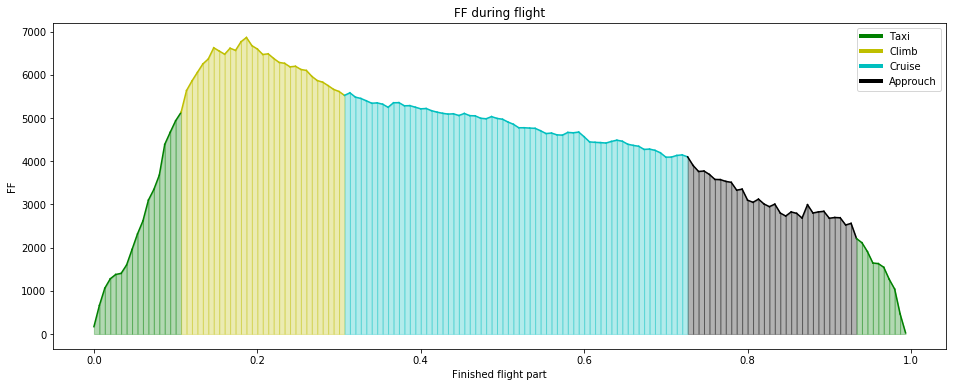

In [0]:
fig, axpa = plt.subplots(1,1, figsize=(16, 6))
prev = fins.iloc[0]
counter=0
for key,val in fins.iloc[1:].iterrows():
  axpa.plot([prev["part"],val["part"]],[prev["cons"],val["cons"]],color=val["type"])
  axpa.fill_between(
    [prev["part"],val["part"]], [prev["cons"],val["cons"]], color=val["type"], alpha=0.3
  )
  prev=val

axpa.title.set_text('FF during flight')
axpa.set_xlabel('Finished flight part')
axpa.set_ylabel('FF')

custom_lines=[(Line2D([0], [0], color=col[1], lw=4)) for col in colors.items()][1:-1]
plt.legend(custom_lines,["Taxi","Climb","Cruise","Approuch"])
plt.show()



*   We can see from graph that plane during climb through dense layers of air consumes most of fule.
*   And later during the flight plane becomes lighter and consumes less fuel. 


<div>There is also 3 stages of flight (Preflight, Rollout, Takeoff) that are not represented in the graph because they are too short to be shown with this graph approximation level.</div>
<div>First Taxi stage may be a little bit larger because of the same reason (Takeoff stage is between it and climb) 

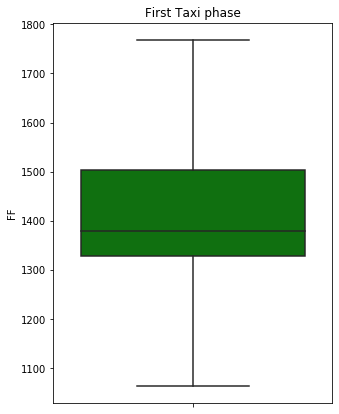

In [0]:
fig, axta = plt.subplots(1,1, figsize=(5, 7))
lgmask = np.logical_and(forplot["PH"]==2,forplot["part"]<0.5)
sns.boxplot(forplot[lgmask]["FF"],orient="v",showfliers=False,color="g",ax=axta)
axta.title.set_text('First Taxi phase')
plt.show()

# Model and hyper parameter selection

In [0]:
msks = 50000
mask=np.concatenate([np.zeros(train_fin_X.shape[0]-msks),np.ones(msks)]).astype("bool")
np.random.shuffle(mask)

In [0]:
ppltr=Pipeline(steps=[
                    ("target",TargetEncoder(cols=unval)),
                    ("main",ct)
])
train_fin_X=ppl_to_df(ppltr,"main",train_X,train_y)

In [0]:
#train_fin_X.drop(columns=["FF"],inplace=True)
test_fin=ppl_to_df(ppltr,"main",test_X,test_y,False)

In [0]:
gb_mod=GradientBoostingRegressor(n_estimators=200,learning_rate=0.2,loss='huber',max_depth=8,min_samples_leaf=5)

In [0]:
gb_mod.fit(train_fin_X[mask],train_y[mask])
mean_squared_error(test_y,gb_mod.predict(test_fin))

48790.36746423223

In [0]:
xg_reg  = XGBRegressor(n_estimators=1000,max_depth=8,gamma=150,reg_lambda=80,learning_rate=0.1,subsample=0.25)

In [0]:
xg_reg.fit(train_fin_X[mask], train_y[mask], 
             early_stopping_rounds=5, 
             eval_set=[(test_fin, test_y)], 
             verbose=False)
mean_squared_error(test_y,xg_reg.predict(test_fin))

[23:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


102681.73093613835

In [0]:
searc_rf=RandomForestRegressor(n_estimators=50)
searc_rf.fit(train_fin_X[mask],train_y[mask])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
mean_squared_error(test_y,searc_rf.predict(test_fin))

50025.12094626306

# Final model

In [0]:
traincnc_X = pd.concat([trainimp_X,test_X[trainimp_X.columns]],ignore_index=True)
taincnc_y =  pd.concat([train_y,test_y],ignore_index=True)

In [0]:
train_cnX=ppl_to_df(ppltr,"main",traincnc_X,taincnc_y)

In [0]:
fmd=GradientBoostingRegressor(n_estimators=200,learning_rate=0.2,loss='huber',max_depth=8,min_samples_leaf=5)
fmd.fit(train_cnX,taincnc_y)

In [0]:
val_fin=ppl_to_df(ppltr,"main",val_X,val_y,False)
mean_squared_error(test_y,gb_mod.predict(val_fin))